<a href="https://colab.research.google.com/github/alons-y/semana4/blob/main/Vectoriacionez8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import os
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
!pip install librosa scikit-learn



In [4]:
from google.colab import drive
drive.mount('/content/drive')

# Ruta donde están los audios
ruta_comandos = '/content/drive/MyDrive/COMANDOSC'


Mounted at /content/drive


In [11]:
import os

# Ruta a tu carpeta
ruta_comandos = "/content/drive/MyDrive/COMANDOSC"

# Listar archivos
if os.path.exists(ruta_comandos):
    archivos = os.listdir(ruta_comandos)
    print("Archivos encontrados en la carpeta:")
    for a in archivos:
        print(a)
else:
    print("⚠️ La carpeta no existe. Verifica la ruta.")



Archivos encontrados en la carpeta:
stop
start
pause
next


In [12]:
import os
import numpy as np
import scipy.io.wavfile as wav

def cargar_audios(ruta_carpeta):
    audios = {}
    fs_global = None

    for carpeta, _, archivos in os.walk(ruta_carpeta):
        for archivo in archivos:
            if archivo.endswith(".wav"):
                etiqueta = os.path.basename(carpeta)  # nombre de la subcarpeta como etiqueta
                if etiqueta not in audios:
                    audios[etiqueta] = []
                fs, data = wav.read(os.path.join(carpeta, archivo))
                if fs_global is None:
                    fs_global = fs
                elif fs != fs_global:
                    raise ValueError(f"Frecuencia inconsistente en {archivo}")
                audios[etiqueta].append(data.astype(np.float32))

    if fs_global is None:
        raise FileNotFoundError("No se encontraron archivos .wav en la carpeta.")

    return audios, fs_global


def preenfasis(senal, coef=0.95):
    return np.append(senal[0], senal[1:] - coef * senal[:-1])

def dividir_en_frames(senal, frame_size=320, hop_size=128):
    num_frames = 1 + int((len(senal) - frame_size) / hop_size)
    return np.stack([senal[i*hop_size : i*hop_size + frame_size] for i in range(num_frames)])

def aplicar_ventana(frames):
    hamming = np.hamming(frames.shape[1])
    return frames * hamming

def cruces_por_cero(frame):
    signos = np.sign(frame)
    signos[signos == 0] = -1
    return np.sum(signos[:-1] != signos[1:])

def detectar_voz_por_cruces(frames, umbral=30):
    return np.array([frame for frame in frames if cruces_por_cero(frame) > umbral])

def procesar_audio(senal):
    señal_pre = preenfasis(senal)
    frames = dividir_en_frames(señal_pre)
    frames_win = aplicar_ventana(frames)
    frames_voz = detectar_voz_por_cruces(frames_win)
    return frames_voz

def procesar_dataset(ruta_carpeta):
    audios, fs = cargar_audios(ruta_carpeta)
    dataset_procesado = {}
    for etiqueta, señales in audios.items():
        dataset_procesado[etiqueta] = [procesar_audio(s) for s in señales]
    return dataset_procesado, fs


In [13]:
dataset, fs = procesar_dataset(ruta_comandos)
print(f"Frecuencia de muestreo: {fs}")
print("Comandos procesados:", list(dataset.keys()))
print("Frames detectados (ejemplo):", len(dataset["start"][0]))


Frecuencia de muestreo: 16000
Comandos procesados: ['stop', 'start', 'pause', 'next']
Frames detectados (ejemplo): 123


pARTE 2

In [17]:
import numpy as np
import librosa
from sklearn.cluster import KMeans

# 1. Calcular LPC para un frame (usamos orden 12 → devuelve 13 coef, omitimos el primero)
def calcular_lpc(frame, orden=12):
    try:
        lpc = librosa.lpc(frame, order=orden)
        return lpc[1:]  # omitimos el coeficiente a[0]
    except np.linalg.LinAlgError:
        return None


# 2. Extraer LPCs para una lista de frames
def extraer_lpcs(frames):
    return [lpc for frame in frames if (lpc := calcular_lpc(frame)) is not None]

# 3. Preparar data de entrenamiento (primeras 10 grabaciones por clase)
def preparar_entrenamiento(dataset, max_grabaciones=10):
    lpc_por_clase = {}
    for clase, grabaciones in dataset.items():
        lpcs = []
        for grabacion in grabaciones[:max_grabaciones]:
            lpcs.extend(extraer_lpcs(grabacion))
        lpc_por_clase[clase] = np.array(lpcs)
    return lpc_por_clase

# 4. Entrenar codebooks con KMeans (8 clusters por clase)
def entrenar_codebooks(lpc_por_clase, n_clusters=8):
    codebooks = {}
    for clase, vectores_lpc in lpc_por_clase.items():
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
        kmeans.fit(vectores_lpc)
        codebooks[clase] = kmeans.cluster_centers_
    return codebooks


In [18]:
# Paso 1: Extraer los LPCs solo de los 10 primeros por clase
lpc_train = preparar_entrenamiento(dataset)

# Paso 2: Entrenar los codebooks por clase
codebooks = entrenar_codebooks(lpc_train)

# Ver un resumen
for clase, codebook in codebooks.items():
    print(f"{clase}: {codebook.shape} centroides")


stop: (8, 12) centroides
start: (8, 12) centroides
pause: (8, 12) centroides
next: (8, 12) centroides


In [19]:
import numpy as np

def distancia_euclidiana(v, codebook):
    dists = np.linalg.norm(codebook - v, axis=1)
    return np.min(dists)

def distancia_itakura_saito(v, codebook):
    dists = []
    for c in codebook:
        num = np.sum((v ** 2) / (c + 1e-6))
        den = np.sum(v ** 2)
        d = np.log(num / (den + 1e-6))
        dists.append(d)
    return np.min(dists)


In [20]:
def clasificar_grabacion(frames, codebooks, metodo='euclidiana'):
    dist_func = distancia_euclidiana if metodo == 'euclidiana' else distancia_itakura_saito

    lpcs = [calcular_lpc(frame) for frame in frames]
    lpcs = [lpc for lpc in lpcs if lpc is not None]

    if len(lpcs) == 0:
        return None  # nada para clasificar

    distancias = {}
    for clase, codebook in codebooks.items():
        total = np.mean([dist_func(v, codebook) for v in lpcs])
        distancias[clase] = total

    return min(distancias, key=distancias.get)


In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluar_pruebas(dataset, codebooks, metodo='euclidiana'):
    etiquetas_reales = []
    etiquetas_predichas = []

    for clase, grabaciones in dataset.items():
        for grabacion in grabaciones[10:15]:  # pruebas: índices 10 a 14
            pred = clasificar_grabacion(grabacion, codebooks, metodo)
            if pred is not None:
                etiquetas_reales.append(clase)
                etiquetas_predichas.append(pred)

    return etiquetas_reales, etiquetas_predichas

def mostrar_matriz_confusion(y_true, y_pred, etiquetas):
    cm = confusion_matrix(y_true, y_pred, labels=etiquetas)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=etiquetas, yticklabels=etiquetas, cmap='Blues')
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title("Matriz de Confusión")
    plt.show()


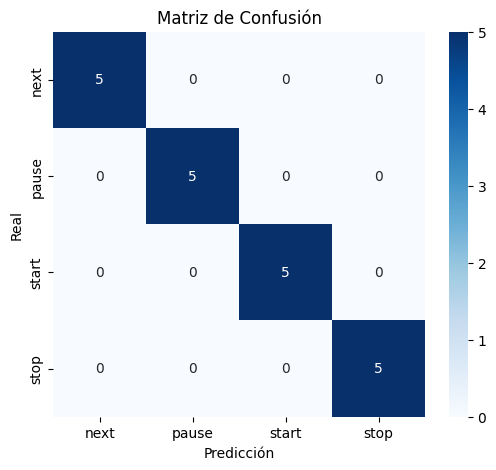

In [22]:
# Evaluación
y_real, y_pred = evaluar_pruebas(dataset, codebooks, metodo='euclidiana')

# Visualización
etiquetas = sorted(codebooks.keys())  # ['next', 'pause', 'start', 'stop']
mostrar_matriz_confusion(y_real, y_pred, etiquetas)


<ipython-input-19-d8ff67d14fec>:12: RuntimeWarning: invalid value encountered in log
  d = np.log(num / (den + 1e-6))


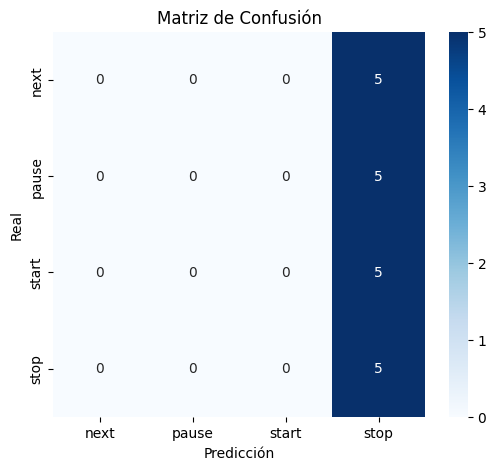

In [23]:
y_real, y_pred = evaluar_pruebas(dataset, codebooks, metodo='itakura')
mostrar_matriz_confusion(y_real, y_pred, etiquetas)
